# How Star Calibration Works

This notebook will walk through the math an logic of how to unwarp/map (word choice??) ASI imagery from (mostly) start to finish.  The source code contained in this package will peform these calculations.

For an ASI using a fish eye lense, each pixel in the collected image corresponds to a particular azimuth and elevation as observed from the site.  The azimuth and elevation can then be used to calculate a latitude and longitude of each pixel, assuming all brightness originates from a single altitude layer.  This allows us to plot ASI images on a latitude/longitude map to assertain exactly where a particular auroral feature occured and compare it with other instruments.

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from asistarcalibration.starcal import StarCal, equalize

# Find Stars
In order to find the relationship between pixels and az/el coordinates, we need to find points in the image with known azimuth and elevations.  Stars and planets are good candidates for this.  They appear as nearly discret points in the image and at any given point in time have well known positions in the night sky.

Find an image from your ASI where stars are clearly visable.  This is likely a time with no clouds and moon down, preferably with minimal aurora.  Because auroral ASI imagers usually have very narrow band filters, the stars are likely to be very dim and additional processing (ie, histogram equalization or contrast adjustments) may be necessary to adequately visualize them.  Coadding multiple images may also be useful, but make sure to not include so many that the stars begin to move appreciably.

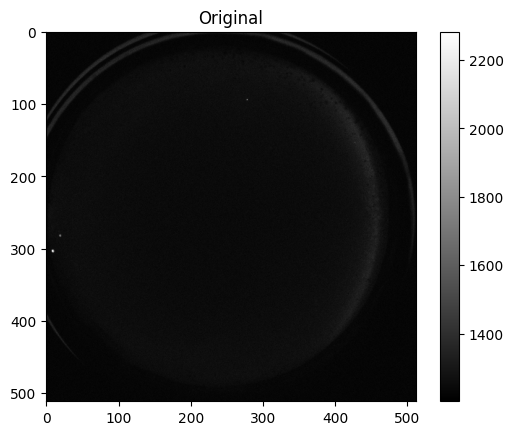

In [2]:
filename = '/Users/e30737/Desktop/Research/SoP_DI/ASIspecinvert_test/starcal/PFRR_20250103_032703_0558.png'
img = Image.open(filename)

fig, ax = plt.subplots()
c = ax.imshow(img, cmap='grey')
ax.set_title('Original')
fig.colorbar(c)

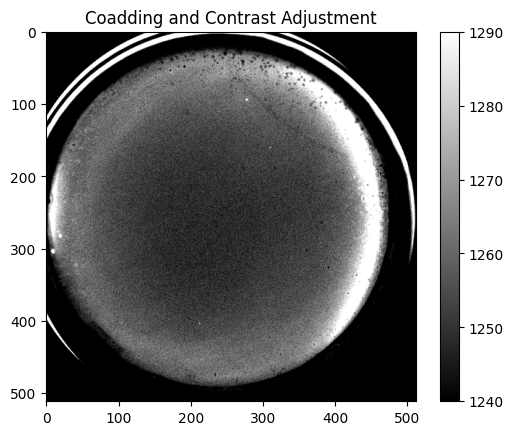

In [3]:
datadir = '/Users/e30737/Desktop/Research/SoP_DI/ASIspecinvert_test/starcal/'
filelist = ['PFRR_20250103_032703_0558.png',
           'PFRR_20250103_032737_0558.png',
           'PFRR_20250103_032711_0558.png',
           'PFRR_20250103_032745_0558.png',
           'PFRR_20250103_032719_0558.png',
           'PFRR_20250103_032753_0558.png',
           'PFRR_20250103_032728_0558.png',
           'PFRR_20250122_030020_0558.png']
imglist = list()
for file in filelist:
    im = Image.open(datadir+file)
    imglist.append(im)
img = np.mean(imglist, axis=0)

img_eq = equalize(img, 98.)

fig, ax = plt.subplots()
c = ax.imshow(img_eq, cmap='grey', vmin=1240, vmax=1290)
ax.set_title('Coadding and Contrast Adjustment')
fig.colorbar(c)

To identify stars, you need an astronomy program such as Stellarium.  Initialize the `StarCal` class with the site longitude, latitude, and time of the frame you will be using to identify stars.  Then call the function `find_stars` with the processed image array as input.  This will cause a window to pop up displaying the image.  Click on stars, and then enter the Hipparcos number of that star on the command line prompt.  This causes the class to identify and log the locations of these stars in the image and then look up their az/el coordinates for that time.  When you are done identifying stars, close the matplotlib window.

**NOTE** I don't think this works in a jupyter notebook - run the example below as a command line program to cause the correct window to open.

Site Information
NONE    None
TIME: 2025-01-03 03:27:00
GLAT: 65.0
GLON: -147.0


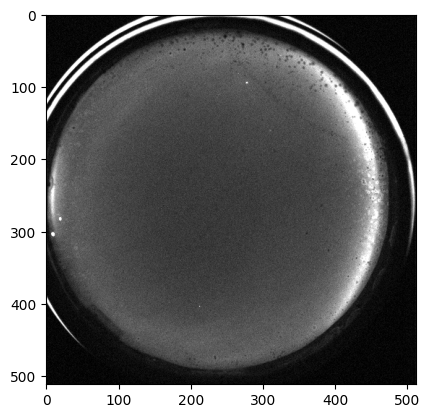

In [4]:
time = dt.datetime(2025,1,3,3,27)
glat = 65.
glon = -147.

cal = StarCal(glat, glon, time)
cal.find_stars(img_eq)

cal.save_starcal_file('test_out.txt')

The output text file will contain the recorded locations of stars, both in az/el and pixel coordinates.  It will be formated something like this.
```
# NONE    None
# 2025-01-03T03:27:00
# GLAT=   65.000000    GLON= -147.000000
################################################################################
           Name      HIP              az              el          x          y
           Vega    91262      287.405400       35.281500 212.560000 407.330000
          Deneb   102098      265.725200       53.689300 186.240000 343.600000
           Sadr   100453      265.675700       47.555100 176.540000 360.230000
         Altair    97649      255.252500       16.566000 103.120000 405.940000
        Capella    24608       80.670900       48.028200 309.530000 162.130000
     Betelgeuse    27989       94.680500       10.356000 323.380000  58.240000
      Aldebaran    21421      109.163700       26.814300 266.580000  83.170000
      Benetnash    67301      346.142200       25.169200 371.860000 375.470000
          Mizar    65378      351.056500       30.233100 371.860000 356.070000
         Alioth    62956      356.061800       30.906200 378.790000 344.990000
     Menkalinan    28360       72.906900       42.757000 333.080000 163.520000
        jupiter        0      104.382729       30.588443 277.664502  94.253247
          venus        0      214.626424        7.959395  18.616883 281.266234
```

# Calculate Az/El Mapping Function
We will use these known points to create a function that maps pixels to az/el sky locations.  The forward transformat (CCD pixel location $(x_c,y_c)$ to az/el $(\phi,\lambda)$) is as follows.

$$ x_n = (x_c-x_0)/R_L $$
$$ y_n = (y_c-y_0)/R_L $$

Here, $x_0$ and $y_0$ are the center of the FoV and $R_L$ is the lens radius.

## Lens Function
Due to warping in the fish-eye lens, the relationship between distance to the center of the FoV in normalized camera pixels and elevation is not a straight forward geometic transform.  An empirically derived cubic function is usually used.
$$ r = \sqrt{x_n^2 + y_n^2} $$
$$ \lambda = A + Br + Cr^2 + Dr^3 $$
Given $\lambda=\pi/2$ at $r=0$ and $\lambda=0$ at $r=1$, two of the four parameters are fully constrained.

$$ A=\pi/2 $$
$$ B = -(\pi/2 + C + D) $$

Azimuth is calculated with arctan plus a rotation such that an azimuth of zero is North.

$$ \phi = \theta - \arctan\left(\frac{y_n}{x_n}\right) $$

In total, this transformation involves six unknown quantities ($x_0, y_0, R_L, C, D, \theta$) that can be fit to with the known star locations.

# Parameter Fitting
The identified star coordinates are used to find the best fit to the six unknown parameters using a standard nonlinear least-squares optimization.  Use the angular separation between the true star az/el and the transformed az/el as the residuals.

For convenience, an output star text file can be reloaded into the `StarCal` class.


/Users/e30737/Desktop/Software/asistarcalibration/src/asistarcalibration/starcal.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.starlist = pd.concat([self.starlist, new_stars])


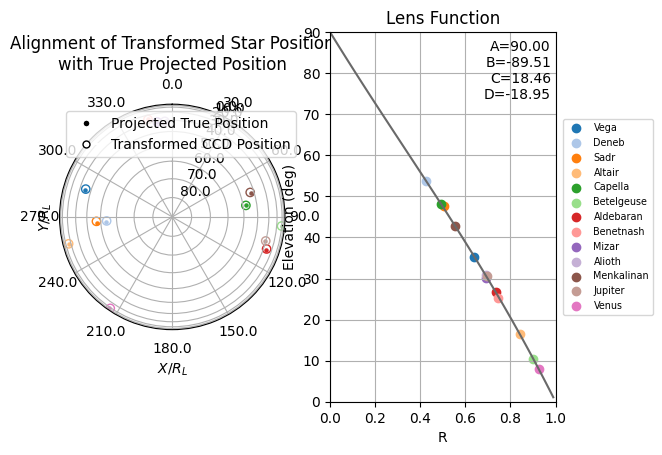

x0 = 239.0077886429748
y0 = 256.8122451392747
RL = 239.35917194345822
theta = 27.792484517958233
A = 1.5707963267948966
B = -1.5622686370665437
C = 0.3222044035351895
D = -0.3307320932635422


In [5]:
cal.load_stars('example_stars.txt')
cal.calculate_calibration_params(*img_eq.shape)

print(f'x0 = {cal.x0}')
print(f'y0 = {cal.y0}')
print(f'RL = {cal.rl}')
print(f'theta = {cal.theta}')
print(f'A = {cal.A}')
print(f'B = {cal.B}')
print(f'C = {cal.C}')
print(f'D = {cal.D}')


The figure that pops up when running `calculate_calibration_params` shows how well the fitted params match the input star positions.  Additionally, the `checkcal` function provides an additional visual check by overlaying elevation circles on the original image.

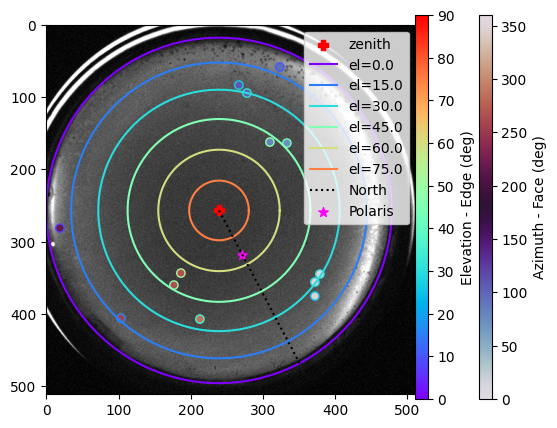

In [6]:
cal.checkcal(img_eq)

# Calculate Position Arrays
Once the parameters that are needed for the transformation have been determined, it is straght forwards to calculate the azimuth and elevation of every pixel in the image.  Generate arrays of the x any y CCD coordinates that form the original image (the shape of the image), then pass these through the transformation function.

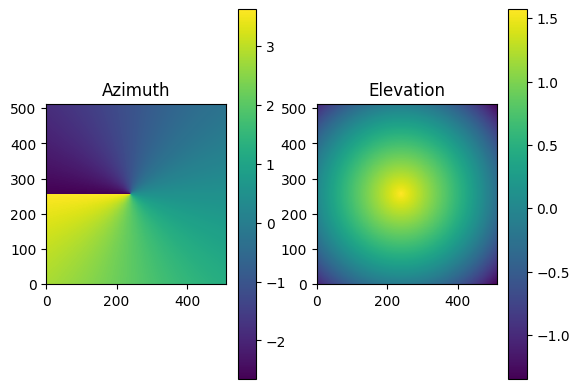

In [9]:
az, el = cal.calculate_position_array(*img_eq.shape)

fig, [ax1, ax2] = plt.subplots(1,2)
c = ax1.pcolormesh(az)
ax1.set_aspect('equal')
ax1.set_title('Azimuth')
fig.colorbar(c)
c = ax2.pcolormesh(el)
ax2.set_aspect('equal')
ax2.set_title('Elevation')
fig.colorbar(c)